In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import MiniBatchKMeans,KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope

import seaborn as sns
sns.set()
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False   #这两行需要手动设置
from mpl_toolkits.mplot3d import Axes3D

RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.

In [2]:
data = pd.read_csv('data/dataset.csv')
submit = pd.read_csv('data/submission.csv')

data.columns = ['风机编号','时间戳','风速','功率','风轮转速']
# data['label'] = 0 # 1为异常数据
print('Data shape:{}'.format(data.shape))
print('Submit shape:{}'.format(submit.shape))
print('训练集与测试集主键是否相同:',(data['时间戳'] == submit['Time']).all())
data.head()

Data shape:(497837, 5)
Submit shape:(497837, 3)
训练集与测试集主键是否相同: True


,风机编号,时间戳,风速,功率,风轮转速
0,1,2017/11/1 0:20,4.188333,65.750000,5.779167
1,1,2017/11/1 0:30,4.042500,120.700000,8.636500
2,1,2017/11/1 0:40,4.137368,135.157895,8.668421
3,1,2017/11/1 0:50,4.274737,157.315789,8.727895
4,1,2017/11/1 1:00,4.108947,129.894737,8.656842


In [3]:
def speed(v):
    return 0 if v>7 else 1
data['风轮转速_01'] = data['风轮转速'].apply(speed)

In [29]:
data1 = data.loc[data['风机编号']==1]
data2 = data.loc[data['风机编号']==2]
data3 = data.loc[data['风机编号']==3]
data4 = data.loc[data['风机编号']==4]
data5 = data.loc[data['风机编号']==5]
data6 = data.loc[data['风机编号']==6]
data7 = data.loc[data['风机编号']==7]
data8 = data.loc[data['风机编号']==8]
data9 = data.loc[data['风机编号']==9]
data10 = data.loc[data['风机编号']==10]
data11 = data.loc[data['风机编号']==11]
data12 = data.loc[data['风机编号']==12]

In [5]:
# 官方给的每个风机的风轮直径、额定功率、切入风速、切出风速、风轮转速范围等
def wheel_diameter(id_):
    id_ = int(id_)
    if id_==5:return 100.5
    elif id_==11:return 115
    elif id_==12:return 104.8
    else:return 99 
def rated_p(id_):
    return 2000
def cutin_wind(id_):
    id_ = int(id_)
    if id_ == 11:return 2.5
    else:        return 3 
def cutout_wind(id_):
    id_ = int(id_)
    if id_==5 or id_==12:return 22
    elif id_==11:        return 19
    else:                return 25
def wheel_speed(id_):
    id_ = int(id_)
    if id_ == 5:return [5.5,19]
    elif id_ == 11:return [5,14]
    elif id_ == 12:return [5.5,17]
    return [8.33,16.8]
    
    
data['风轮直径'] = data['风机编号'].apply(wheel_diameter)
data['额定功率'] = data['风机编号'].apply(rated_p)
data['切入风速'] = data['风机编号'].apply(cutin_wind)
data['切出风速'] = data['风机编号'].apply(cutout_wind)
data['风轮转速范围'] = data['风机编号'].apply(wheel_speed)
data.head()

,风机编号,时间戳,风速,功率,风轮转速,风轮转速_01,风轮直径,额定功率,切入风速,切出风速,风轮转速范围
0,1,2017/11/1 0:20,4.188333,65.750000,5.779167,1,99.0,2000,3.0,25,"[8.33, 16.8]"
1,1,2017/11/1 0:30,4.042500,120.700000,8.636500,0,99.0,2000,3.0,25,"[8.33, 16.8]"
2,1,2017/11/1 0:40,4.137368,135.157895,8.668421,0,99.0,2000,3.0,25,"[8.33, 16.8]"
3,1,2017/11/1 0:50,4.274737,157.315789,8.727895,0,99.0,2000,3.0,25,"[8.33, 16.8]"
4,1,2017/11/1 1:00,4.108947,129.894737,8.656842,0,99.0,2000,3.0,25,"[8.33, 16.8]"


In [6]:
data['时间戳'] = pd.to_datetime(data['时间戳'])
data = data.sort_values('时间戳')
data.head()

,风机编号,时间戳,风速,功率,风轮转速,风轮转速_01,风轮直径,额定功率,切入风速,切出风速,风轮转速范围
79582,3,2017-11-01 00:10:00,4.790909,18.090909,7.315455,0,99.0,2000,3.0,25,"[8.33, 16.8]"
40727,2,2017-11-01 00:10:00,4.637895,103.631579,8.580000,0,99.0,2000,3.0,25,"[8.33, 16.8]"
341260,9,2017-11-01 00:10:00,4.742727,71.090909,5.769091,1,99.0,2000,3.0,25,"[8.33, 16.8]"
302790,8,2017-11-01 00:10:00,4.364211,171.684211,8.713684,0,99.0,2000,3.0,25,"[8.33, 16.8]"
259466,7,2017-11-01 00:10:00,6.537000,290.500000,9.765000,0,99.0,2000,3.0,25,"[8.33, 16.8]"


count    40727.000000
mean         5.734071
std          2.837871
min         -0.050000
25%          3.743079
50%          5.264500
75%          7.293842
max         26.541818
Name: 风速, dtype: float64


<Axes: >

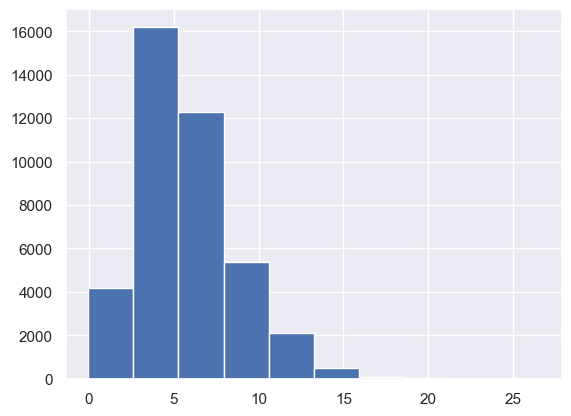

In [7]:
sns.set()
print(data['风速'].loc[data['风机编号']==1].describe())
data['风速'].loc[data['风机编号']==1].hist()

<Axes: xlabel='时间戳'>

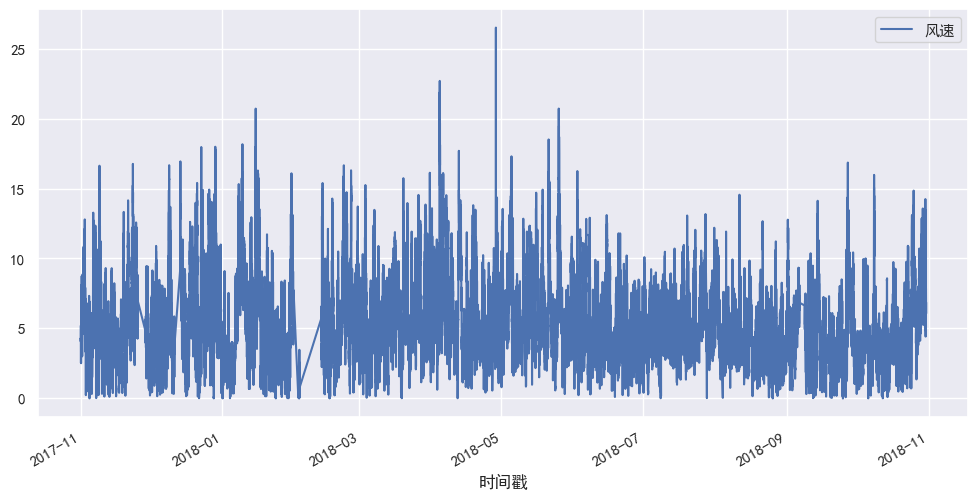

In [8]:
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False
data.loc[data['风机编号']==1].plot(x='时间戳',y='风速',figsize=(12,6))

<Axes: xlabel='时间戳'>

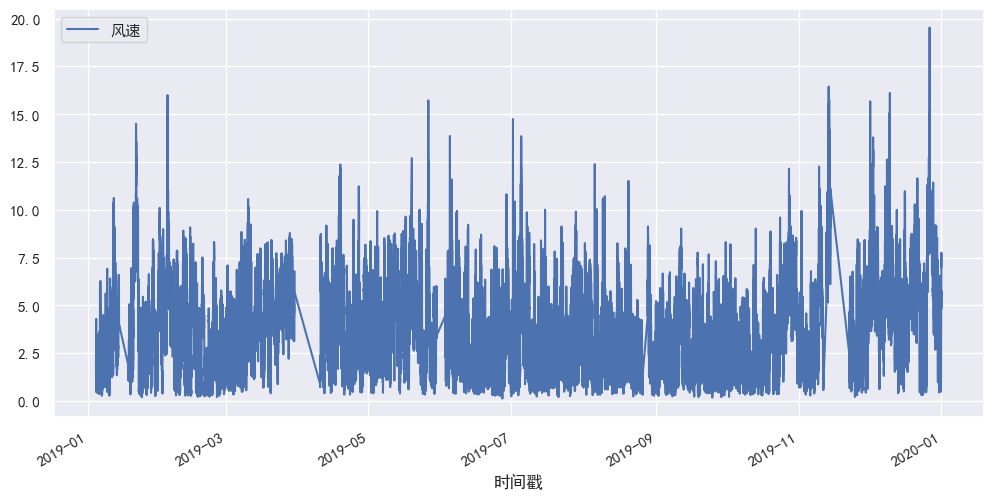

In [9]:
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False
data.loc[data['风机编号']==12].plot(x='时间戳',y='风速',figsize=(12,6))

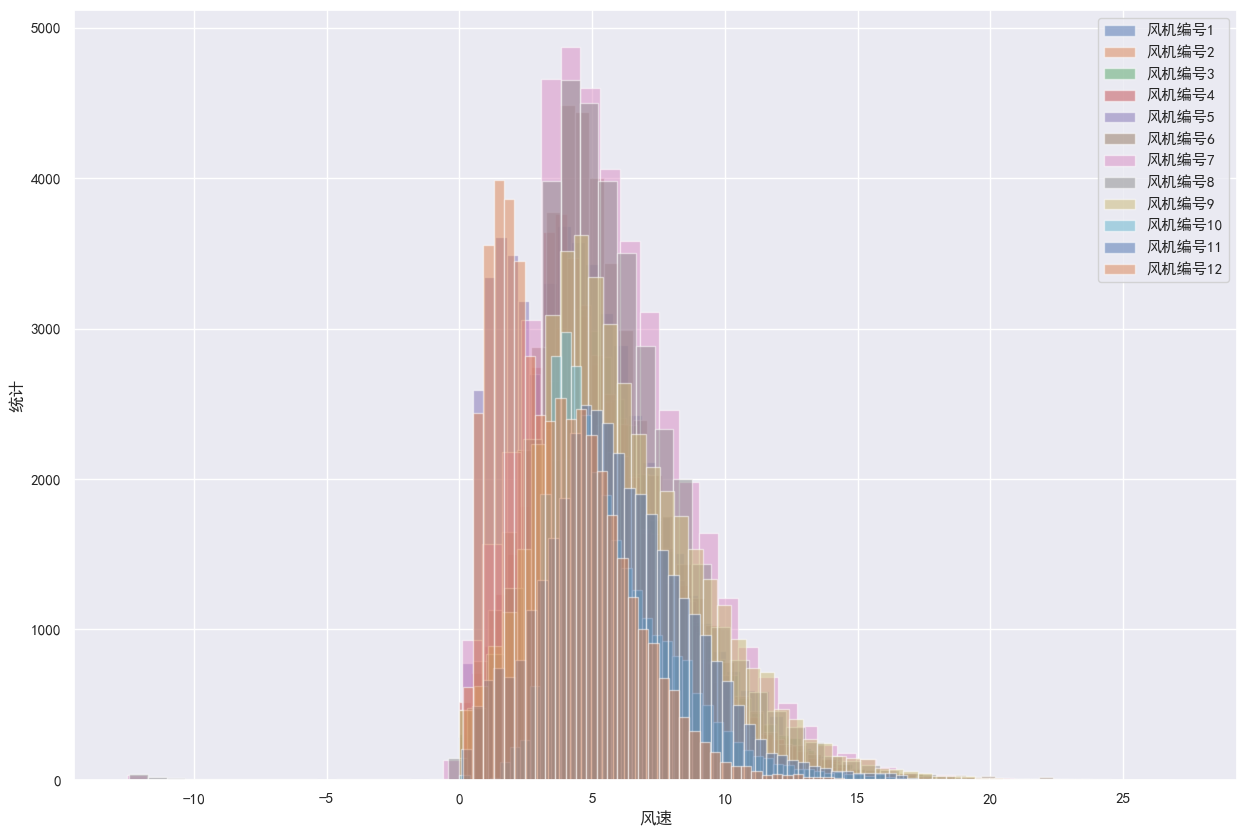

In [10]:
a1 = data.loc[data['风机编号']==1,'风速']
a2 = data.loc[data['风机编号']==2,'风速']
a3 = data.loc[data['风机编号']==3,'风速']
a4 = data.loc[data['风机编号']==4,'风速']
a5 = data.loc[data['风机编号']==5,'风速']
a6 = data.loc[data['风机编号']==6,'风速']
a7 = data.loc[data['风机编号']==7,'风速']
a8 = data.loc[data['风机编号']==8,'风速']
a9 = data.loc[data['风机编号']==9,'风速']
a10 = data.loc[data['风机编号']==10,'风速']
a11 = data.loc[data['风机编号']==11,'风速']
a12 = data.loc[data['风机编号']==12,'风速']
plt.figure(figsize=(15,10))
plt.hist(a1,bins=50 , alpha=0.5,label='风机编号1')
plt.hist(a2,bins=50 , alpha=0.5,label='风机编号2')
plt.hist(a3,bins=50 , alpha=0.5,label='风机编号3')
plt.hist(a4,bins=50 , alpha=0.5,label='风机编号4')
plt.hist(a5,bins=50 , alpha=0.5,label='风机编号5')
plt.hist(a6,bins=50 , alpha=0.5,label='风机编号6')
plt.hist(a7,bins=50 , alpha=0.5,label='风机编号7')
plt.hist(a8,bins=50 , alpha=0.5,label='风机编号8')
plt.hist(a9,bins=50 , alpha=0.5,label='风机编号9')
plt.hist(a10,bins=50 , alpha=0.5,label='风机编号10')
plt.hist(a11,bins=50 , alpha=0.5,label='风机编号11')
plt.hist(a12,bins=50 , alpha=0.5,label='风机编号12')
plt.legend(loc='upper right')
plt.xlabel('风速')
plt.ylabel('统计')
plt.show()

从上面的直方图中可以看出各个风机的风速图像类似

# 基于聚类的异常检测

k-means是一种广泛使用的聚类算法。 它创建了k个具有相似特性的数据组。 不属于这些组的数据实例可能会被标记为异常。 在我们开始k-means聚类之前，我们使用elbow方法来确定最佳聚类数量。

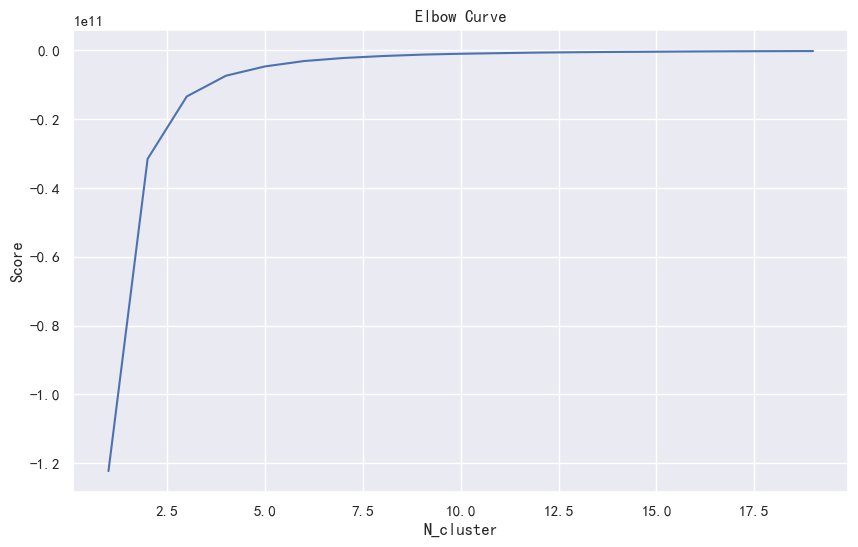

In [11]:
data_num = data[['风速','功率','风轮转速']]
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data_num) for i in n_cluster]
scores = [kmeans[i].score(data_num) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('N_cluster')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

为了找出合理的距离中心数，我们尝试尽可能多的聚类中心数（从1个到20个聚类中心），然后我们画出Elbow曲线，通过观察Elbow曲线,我们发现当我们的聚类中心数量增加到10个以上时Elbow曲线趋于收敛，因此我们大致可以将聚类中心数定为10.

下面我们将K-means算法的n_clusters设置为10,然后我们将数据进行3D可视化。

C:\Users\10116\AppData\Local\Temp\ipykernel_3460\2138029238.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=labels.astype(np.float), edgecolor="k")


Text(0.5, 1.0, 'K Means')

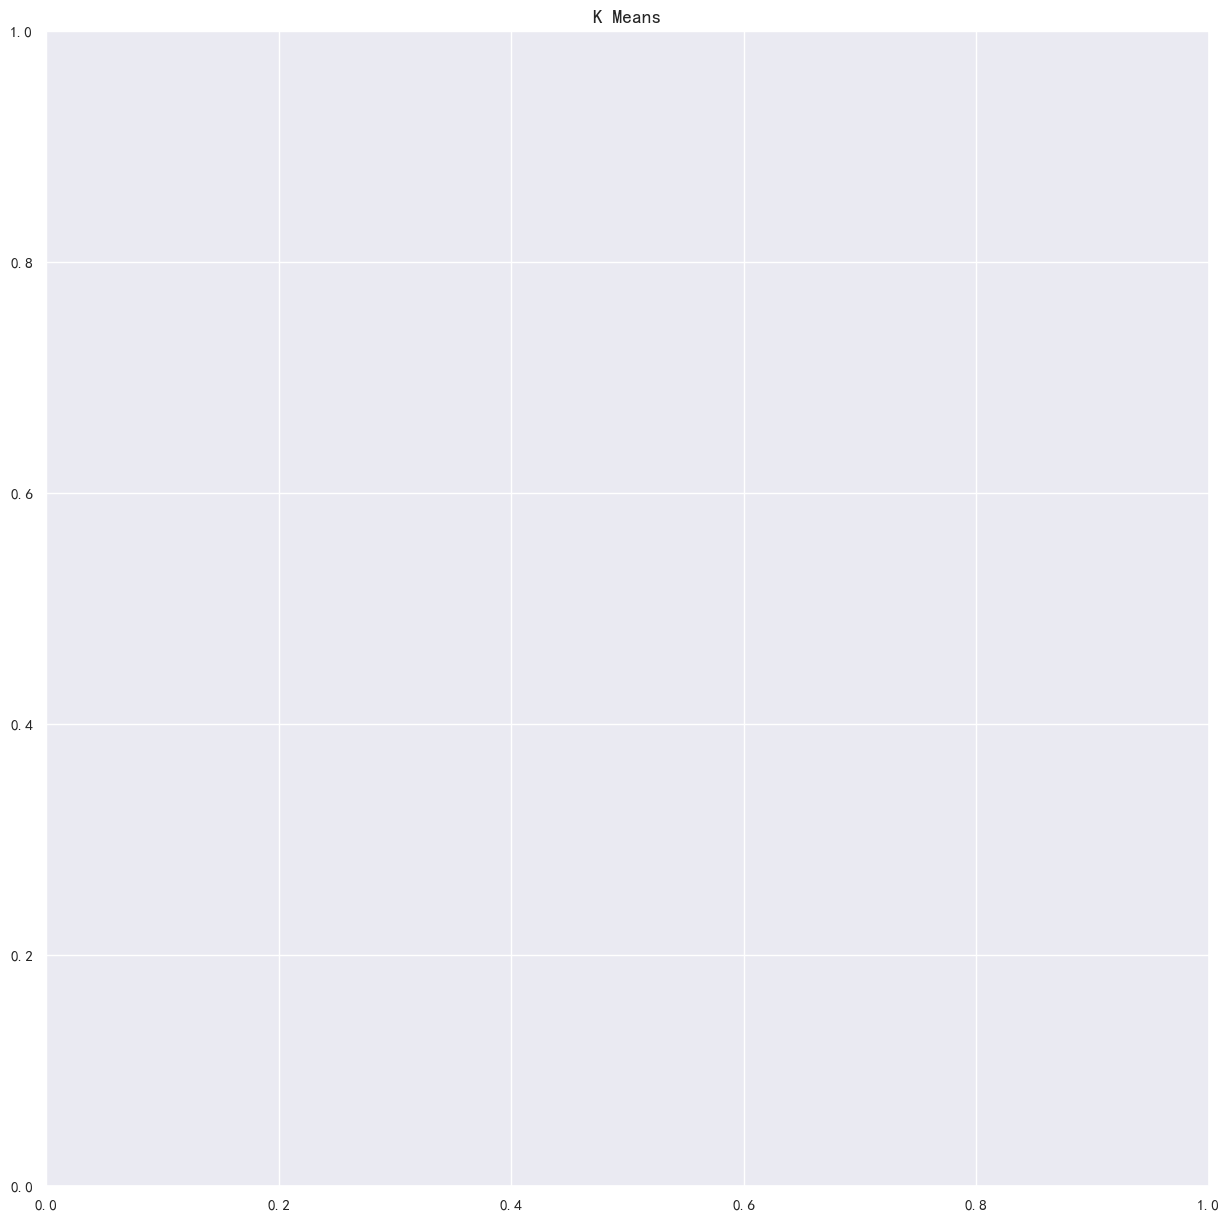

In [12]:
X = data_num
X = X.reset_index(drop=True)
km = KMeans(n_clusters=10)
km.fit(X)
km.predict(X)
labels = km.labels_
 
fig = plt.figure(1, figsize=(15,15))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2],
          c=labels.astype(np.float), edgecolor="k")
# '风速','功率','风轮转速'
ax.set_xlabel("风速")
ax.set_ylabel("功率")
ax.set_zlabel("风轮转速")
plt.title("K Means", fontsize=14)

Text(0.5, 1.0, '风机编号1 K Means')

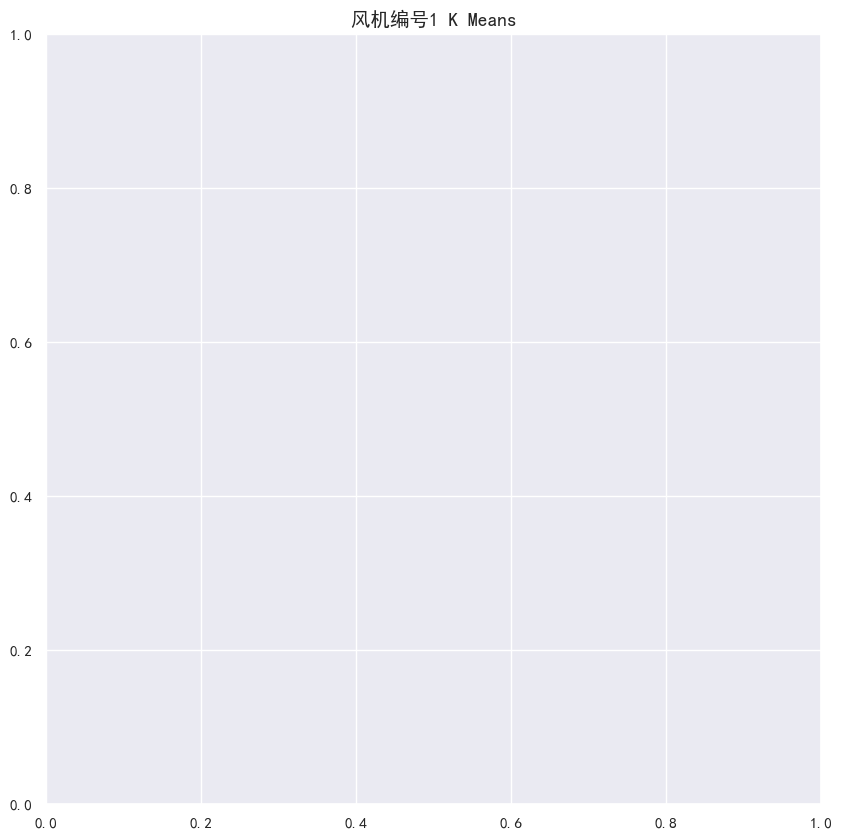

In [13]:
X = data[['风速','功率','风轮转速']].loc[data['风机编号']==1]
X = X.reset_index(drop=True)
km = KMeans(n_clusters=2)
km.fit(X)
km.predict(X)
labels = km.labels_
 
fig = plt.figure(1, figsize=(10,10))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2],
          c=labels.astype(float), edgecolor="k")
# '风速','功率','风轮转速'
ax.set_xlabel("风速")
ax.set_ylabel("功率")
ax.set_zlabel("风轮转速")
plt.title("风机编号1 K Means", fontsize=14)

接下来我们要确定需要保留数据中的哪些主要成分(特征)

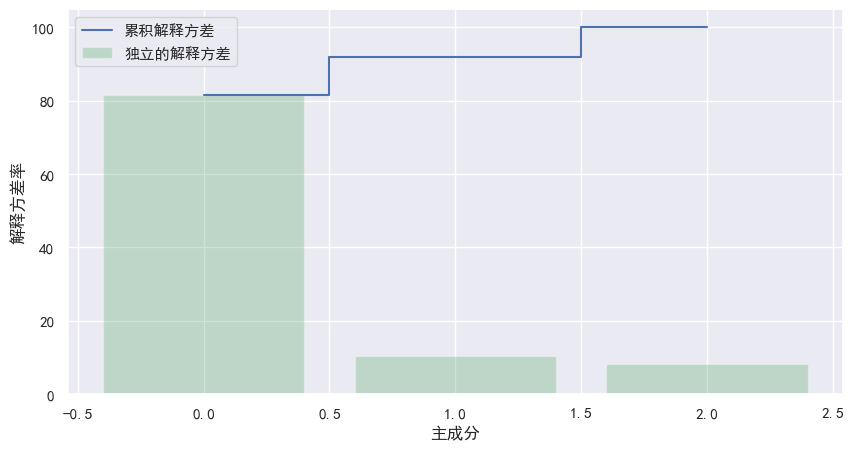

In [14]:
X = data_num.values

# 标准化 均值为0 标准差为1
X_std    = StandardScaler().fit_transform(X)
mean_vec = np.mean(X_std,axis=0)
# 协方差,协方差矩阵反应了特征变量之间的相关性
# 如果两个特征变量之间的协方差为正则说明它们之间是正相关关系
# 如果为负则说明它们之间是负相关关系
cov_mat = np.cov(X_std.T)

# 特征值和特征向量
eig_vals,eig_vecs = np.linalg.eig(cov_mat)
# 特征值对应的特征向量
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key = lambda x: x[0], reverse= True)
# 特征之求和
eig_sum = sum(eig_vals)


# 解释方差
var_exp = [(i/eig_sum)*100 for i in sorted(eig_vals, reverse=True)]
# 累计的解释方差
cum_var_exp = np.cumsum(var_exp)

plt.figure(figsize=(10,5))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='独立的解释方差', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='累积解释方差')
plt.ylabel('解释方差率')
plt.xlabel('主成分')
plt.legend(loc='best')
plt.show()

我们首先对数据进行标准化处理(StandardScaler)，
然后再计算特征变量之间的协方差矩阵,协方差矩阵反应了特征变量之间的相关性，
如果两个特征变量之间的协方差为正则说明它们之间是正相关关系,如果为负则说明它们之间是负相关关系，如果为0则说明特征变量之间是相互独立的关系,
不存在相关关系(有时候我们也会用相关系数矩阵来代替协方差矩阵)。
然后在协方差矩阵的基础上又计算了协方差矩阵的特征值和特征向量，
根据特征值计算出每个主成分(特征)的解释方差,以及累计解释方差，
我们这样做的目的是为了下一步做主成分分析(PCA)挑选出特征变量中的主成分。
我们挑选前1个主成分，因为它们的累计解释方差为80%。

从上图可知我们的三个主成分,
第一个主成分(特征)解释了将近80%的方差变化,第二个主成分解释了近15%的方差变化,那么前1个主成分解释了近80%的方差。
因此接下来我们将使用PCA算法进行降维并将设置参数n_components=1。

In [15]:
# 标准化处理,均值为0,标准差为1
X_std = StandardScaler().fit_transform(data_num.values)
data_std = pd.DataFrame(X_std)
 
#将特征维度降到1
pca = PCA(n_components=1)
data_std = pca.fit_transform(data_std)
# 降维后将1个新特征进行标准化处理
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data_std)
data_std = pd.DataFrame(np_scaled)
 
kmeans = [KMeans(n_clusters=i).fit(data_std) for i in n_cluster]
data['cluster'] = kmeans[9].predict(data_std) # 刚才Elbow曲线10类基本收敛了，故还是选择10类
data.index = data_std.index
data['principal_feature1'] = data_std[0]
data.head()

,风机编号,时间戳,风速,功率,风轮转速,风轮转速_01,风轮直径,额定功率,切入风速,切出风速,风轮转速范围,cluster,principal_feature1
0,3,2017-11-01 00:10:00,4.790909,18.090909,7.315455,0,99.0,2000,3.0,25,"[8.33, 16.8]",3,-0.349759
1,2,2017-11-01 00:10:00,4.637895,103.631579,8.580000,0,99.0,2000,3.0,25,"[8.33, 16.8]",3,-0.213482
2,9,2017-11-01 00:10:00,4.742727,71.090909,5.769091,1,99.0,2000,3.0,25,"[8.33, 16.8]",3,-0.426672
3,8,2017-11-01 00:10:00,4.364211,171.684211,8.713684,0,99.0,2000,3.0,25,"[8.33, 16.8]",3,-0.186585
4,7,2017-11-01 00:10:00,6.537000,290.500000,9.765000,0,99.0,2000,3.0,25,"[8.33, 16.8]",6,0.249320


 基于聚类的异常检测中的假设是，如果我们对数据进行聚类，则正常数据将属于聚类，而异常将不属于任何聚类或属于小聚类。 我们使用以下步骤来查找和可视化异常值。

    计算每个数据点与其最近的聚类中心之间的距离。 最大的距离被认为是异常的。
    设定一个异常值的比例outliers_fraction为40%,这样设置是因为在标准正太分布的情况下（N(0,1)）我们一般认定3个标准差以外的数据为异常值,3个标准差以内的数据包含了数据集中99%以上的数据,所以剩下的1%的数据可以视为异常值。
    根据异常值比例outliers_fraction，计算异常值的数量number_of_outliers
    设定一个判定异常值的阈值threshold
    通过阈值threshold来判定数据是否为异常值
    对数据进行可视化(包含正常数据和异常数据)

In [16]:
# 计算每个数据点到其聚类中心的距离
def getDistanceByPoint(data, model):
    distance = pd.Series(index=data.index)  # Initialize the Series with the same index as data
    for i in range(len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]]
        distance[i] = np.linalg.norm(Xa - Xb)  # Directly assign value
    return distance
 
#设置异常值比例
outliers_fraction = 0.4
 
# 得到每个点到取聚类中心的距离，我们设置了10个聚类中心，kmeans[9]表示有10个聚类中心的模型
distance = getDistanceByPoint(data_std, kmeans[9])
 
#根据异常值比例outliers_fraction计算异常值的数量
number_of_outliers = int(outliers_fraction*len(distance))
 
#设定异常值的阈值
threshold = distance.nlargest(number_of_outliers).min()
 
#根据阈值来判断是否为异常值
data['anomaly1'] = (distance >= threshold).astype(int)

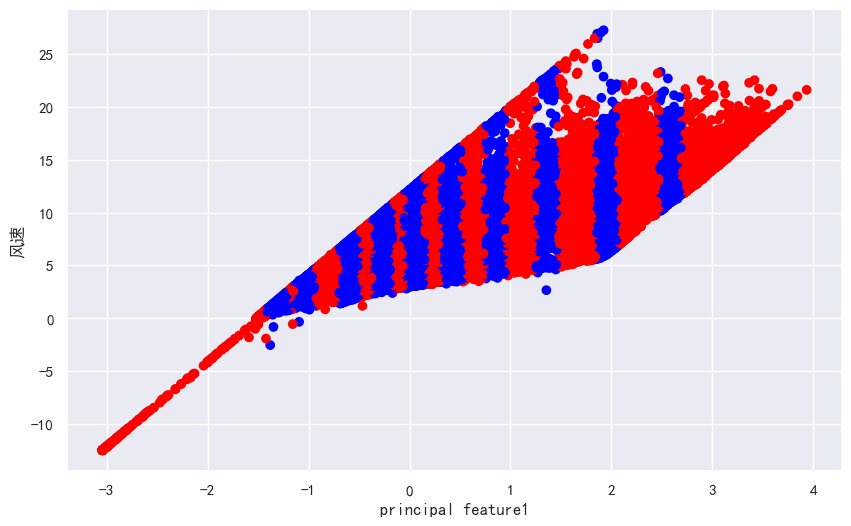

In [17]:
#数据可视化
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(data['principal_feature1'],data['风速'],c=data["anomaly1"].apply(lambda x: colors[x]))
plt.xlabel('principal feature1')
plt.ylabel('风速')
plt.show()

上图中红色的点即是被认定的异常值，它们大约占总数据量的40%。 

In [18]:
data['anomaly1'].value_counts()

anomaly1
0    298703
1    199134
Name: count, dtype: int64

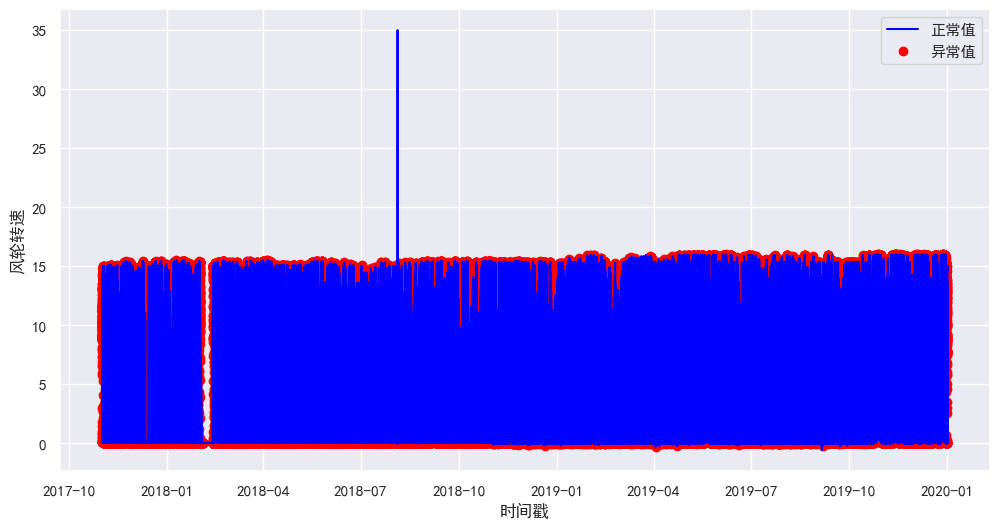

In [19]:
fig, ax = plt.subplots(figsize=(12,6))
 
a = data.loc[data['anomaly1'] == 1, ['时间戳', '风轮转速']] #anomaly
 
ax.plot(data['时间戳'], data['风轮转速'], color='blue', label='正常值')
ax.scatter(a['时间戳'],a['风轮转速'], color='red', label='异常值')
plt.xlabel('时间戳')
plt.ylabel('风轮转速')
plt.legend()
plt.show()

从上图可知,经过PCA和KMeans计算出的异常值，它们的风轮转速大多位于区间的最高点和最低点处，这应该是合理的。

# 孤立森林(IsolationForest)异常检测
IsolationForest算法它是一种集成算法(类似于随机森林)主要用于挖掘异常(Anomaly)数据，或者说离群点挖掘，总之是在一大堆数据中，找出与其它数据的规律不太符合的数据。该算法不采样任何基于聚类或距离的方法，因此他和那些基于距离的的异常值检测算法有着根本上的不同，孤立森林认定异常值的原则是异常值是少数的和不同的数据。它通常用于网络安全中的攻击检测和流量异常等分析，金融机构则用于挖掘出欺诈行为。

    当我们使用IsolationForest算法时需要设置一个异常值比例的参数contamination， 该参数的作用类似于之前的outliers_fraction。
    使用 fit 方法对孤立森林模型进行训练
    使用 predict 方法去发现数据中的异常值。返回1表示正常值，-1表示异常值。

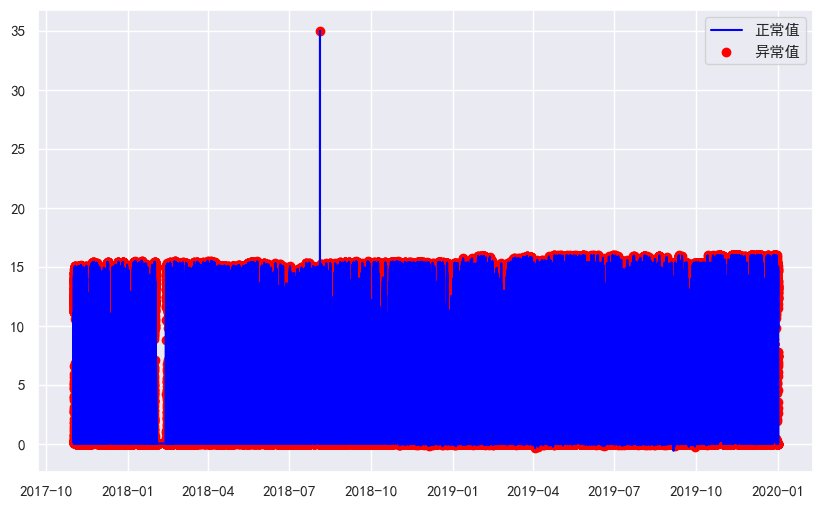

In [20]:
# 训练孤立森林模型
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data_std)
 
#返回1表示正常值，-1表示异常值
data['anomaly2'] = pd.Series(model.predict(data_std)) 
 
fig, ax = plt.subplots(figsize=(10,6))
a = data.loc[data['anomaly2'] == -1, ['时间戳', '风轮转速']] #异常值
ax.plot(data['时间戳'], data['风轮转速'], color='blue', label = '正常值')
ax.scatter(a['时间戳'],a['风轮转速'], color='red', label = '异常值')
plt.legend()
plt.show()

从上图可知，使用孤立森林预测的异常值，它们的风轮转速大多位于区间的最高点或最低点处。

# 支持向量机(SVM)的异常检测
SVM通常应用于监督式学习，但OneClassSVM算法可用于将异常检测这样的无监督式学习，它学习一个用于异常检测的决策函数其主要功能将新数据分类为与训练集相似的正常值或不相似的异常值。

SVM使用大边距的方法，它用于异常检测的主要思想是:将数据密度较高的区域分类为正，将数据密度较低的区域分类为负

    在训练OneClassSVM模型时，我们需要设置参数nu = outliers_fraction，它是训练误差分数的上限和支持向量分数的下限，并且必须在0和1之间。基本上它代表了我们期望的异常值在我们的数据集中的比例。
    指定要在算法中使用的核类型：rbf。 它使SVM能够使用非线性函数将超空间投影到更高维度。
    gamma是RBF内核类型的参数，并控制各个训练样本的影响 - 这会影响模型的“平滑度”。 
    predict 对数据进行分类，因为我们的模型是单类模型，所以返回+1或-1，-1表示是异常值，1表示是正常值。

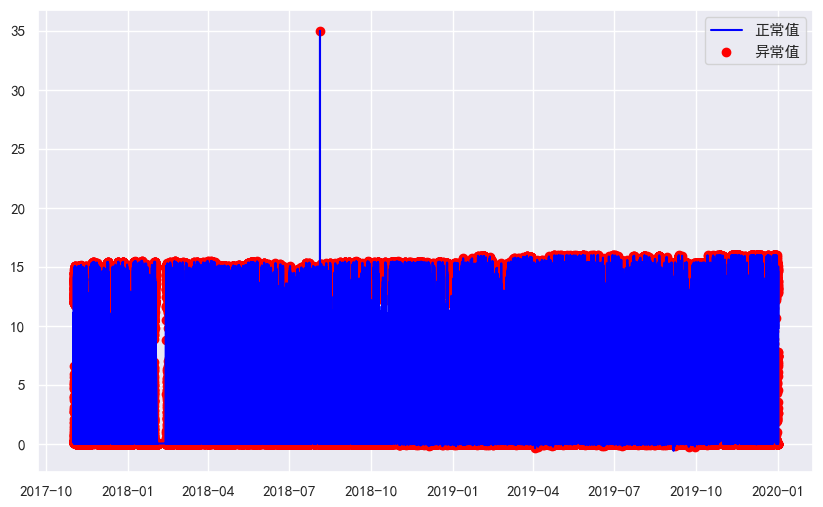

In [21]:
# # 训练 oneclassSVM 模型
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data_std)
 
data['anomaly3'] = pd.Series(model.predict(data_std))
fig, ax = plt.subplots(figsize=(10,6))
 
a = data.loc[data['anomaly3'] == -1, ['时间戳', '风轮转速']] #异常值

ax.plot(data['时间戳'], data['风轮转速'], color='blue', label = '正常值')
ax.scatter(a['时间戳'],a['风轮转速'], color='red', label = '异常值')
plt.legend()
plt.show()

从上图可知，使用OneClassSVM预测的异常值，它们的风轮转速大多位于区间的最高点或最低点处。

# 基于高斯概分布的异常检测

高斯分布也称为正态分布。 它可以被用来进行异常值检测，不过我们首先要假设我们的数据是正态分布的。 不过这个假设不能适应于所有数据集。但如果我们做了这种假设那么它将会有一种有效的方法来发现异常值。

Scikit-Learn的EllipticEnvelope模型，它在假设我们的数据是多元高斯分布的基础上计算出高斯分布的一些关键参数过程。过程大致如下:

    根据前面定义的类别创建两个不同的数据集 ： search_Sat_night和Search_Non_Sat_night。
    在每个类别应用EllipticEnvelope（高斯分布）。
    我们设置contamination参数，它表示我们数据集中异常值的比例。
    使用decision_function来计算给定数据的决策函数。 它等于移位的马氏距离(Mahalanobis distances)。 异常值的阈值为0，这确保了与其他异常值检测算法的兼容性。
    使用predict 来预测数据是否为异常值(1 正常值, -1 异常值)

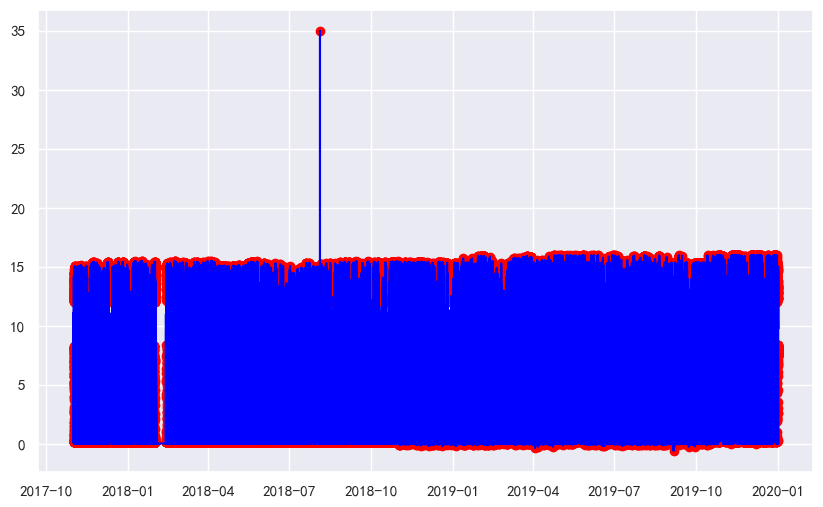

In [22]:
# 基于高斯概分布的异常检测
df_class0 = data.loc[data['风轮转速'] >7, '风轮转速']
df_class1 = data.loc[data['风轮转速'] <=7, '风轮转速']
 
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)
 
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)
 
df_class = pd.concat([df_class0, df_class1])

data['anomaly4'] = df_class['anomaly']
fig, ax = plt.subplots(figsize=(10, 6))
a = data.loc[data['anomaly4'] == -1, ('时间戳', '风轮转速')] 
ax.plot(data['时间戳'], data['风轮转速'], color='blue', label = '正常值')
ax.scatter(a['时间戳'],a['风轮转速'], color='red', label = '异常值')
plt.show()

 从上图可知，使用EllipticEnvelope预测的异常值，它们的风轮转速大多位于区间的最高点处，而在最低点处没有出现异常值。

到目前为止，我们已经用四种不同的方法进行了风轮数据异常检测。 因为我们的异常检测是无监督学习。 在构建模型之后，我们不知道他们的异常检测效果怎么样，因为我们没有办法可以对他们进行测试。 通常异常检测只有在实际的应用场景中才能测试出它的效果。

In [23]:
# anomaly1 == 1 异常值
# anomaly2 == -1 异常值
# anomaly3 == -1 异常值
# anomaly4 == -1 异常值
data.head()

,风机编号,时间戳,风速,功率,风轮转速,风轮转速_01,风轮直径,额定功率,切入风速,切出风速,风轮转速范围,cluster,principal_feature1,anomaly1,anomaly2,anomaly3,anomaly4
0,3,2017-11-01 00:10:00,4.790909,18.090909,7.315455,0,99.0,2000,3.0,25,"[8.33, 16.8]",3,-0.349759,0,1,1,-1
1,2,2017-11-01 00:10:00,4.637895,103.631579,8.580000,0,99.0,2000,3.0,25,"[8.33, 16.8]",3,-0.213482,0,1,1,1
2,9,2017-11-01 00:10:00,4.742727,71.090909,5.769091,1,99.0,2000,3.0,25,"[8.33, 16.8]",3,-0.426672,1,1,1,-1
3,8,2017-11-01 00:10:00,4.364211,171.684211,8.713684,0,99.0,2000,3.0,25,"[8.33, 16.8]",3,-0.186585,0,1,1,1
4,7,2017-11-01 00:10:00,6.537000,290.500000,9.765000,0,99.0,2000,3.0,25,"[8.33, 16.8]",6,0.249320,1,1,1,1


In [24]:
def anomaly_process(df):
    df = df.copy()
    df.loc[:, 'anomaly1'] = df.loc[:, 'anomaly1'].map({ 0:0, 1:1})
    df.loc[:, 'anomaly2'] = df.loc[:, 'anomaly2'].map({ 1:0, -1:1})
    df.loc[:, 'anomaly3'] = df.loc[:, 'anomaly3'].map({ 1:0, -1:1})
    df.loc[:, 'anomaly4'] = df.loc[:, 'anomaly4'].map({ 1:0, -1:1})
    return df
data = anomaly_process(data)
data.head()

C:\Users\10116\AppData\Local\Temp\ipykernel_3460\3715363406.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 1 ... 0 0 1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df.loc[:, 'anomaly1'] = df.loc[:, 'anomaly1'].map({ 0:0, 1:1})
C:\Users\10116\AppData\Local\Temp\ipykernel_3460\3715363406.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 1 0 1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df.loc[:, 'anomaly2'] = df.loc[:, 'anomaly2'].map({ 1:0, -1:1})
C:\Users\10116\AppData\Local\Temp\ipykernel_3460\3715363406.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 1 0 1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.

,风机编号,时间戳,风速,功率,风轮转速,风轮转速_01,风轮直径,额定功率,切入风速,切出风速,风轮转速范围,cluster,principal_feature1,anomaly1,anomaly2,anomaly3,anomaly4
0,3,2017-11-01 00:10:00,4.790909,18.090909,7.315455,0,99.0,2000,3.0,25,"[8.33, 16.8]",3,-0.349759,0,0,0,1
1,2,2017-11-01 00:10:00,4.637895,103.631579,8.580000,0,99.0,2000,3.0,25,"[8.33, 16.8]",3,-0.213482,0,0,0,0
2,9,2017-11-01 00:10:00,4.742727,71.090909,5.769091,1,99.0,2000,3.0,25,"[8.33, 16.8]",3,-0.426672,1,0,0,1
3,8,2017-11-01 00:10:00,4.364211,171.684211,8.713684,0,99.0,2000,3.0,25,"[8.33, 16.8]",3,-0.186585,0,0,0,0
4,7,2017-11-01 00:10:00,6.537000,290.500000,9.765000,0,99.0,2000,3.0,25,"[8.33, 16.8]",6,0.249320,1,0,0,0


In [25]:
data['sum'] = data['风轮转速_01'] + data['anomaly1'] + data['anomaly2'] + data['anomaly3'] + data['anomaly4']
submit.loc[:,'label'] = data.loc[:,'sum'].map({0:0,1:1,2:1,3:1,4:1,5:1})

In [27]:
submit.to_csv('output/baseline.csv',index=False)
submit.head()

,WindNumber,Time,label
0,1,2017/11/1 0:20,1
1,1,2017/11/1 0:30,0
2,1,2017/11/1 0:40,1
3,1,2017/11/1 0:50,0
4,1,2017/11/1 1:00,1
